In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
kerasBKED = os.environ["KERAS_BACKEND"] 
print(kerasBKED)

tensorflow


In [0]:
import keras
from keras.models import load_model
from keras.datasets import cifar10
from keras.layers import Input, Dense,Reshape, Conv2D,Conv2DTranspose, MaxPooling2D, UpSampling2D
from keras.layers import BatchNormalization, Activation, Flatten, Dropout
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
import os
import matplotlib.pyplot as plt

import numpy as np
from keras.utils import np_utils
from keras.callbacks import TensorBoard
from keras import backend as K

In [0]:
batch_size = 32
num_classes = 10
epochs = 100

In [0]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
x_val = x_test[:7000]
x_test = x_test[7000:]

170500096/170498071 [==============================] - 4s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [0]:
noise_factor = 0.1
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 
x_val_noisy = x_val + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_val.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
x_val_noisy = np.clip(x_val_noisy, 0., 1.)

In [0]:
def showOrigDec(orig, noise, num=10):
    import matplotlib.pyplot as plt
    n = num
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i+1)
        plt.imshow(orig[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display original
        ax = plt.subplot(2, n, i +1 + n)
        plt.imshow(noise[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

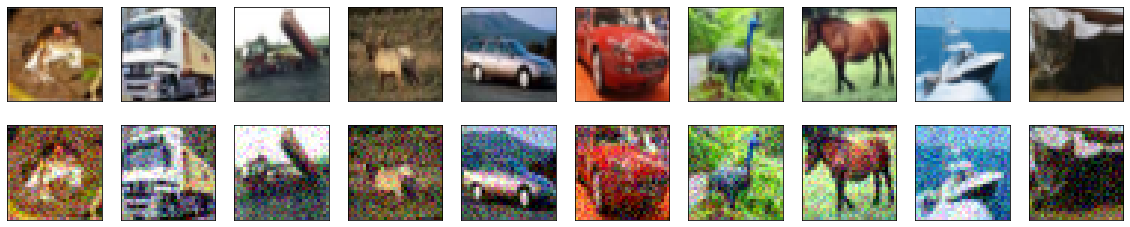

In [0]:
showOrigDec(x_train, x_train_noisy)

In [0]:
input_img = Input(shape=(32, 32, 3))
x = Conv2D(32, (3, 3), padding='same')(input_img)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), padding='same')(encoded)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(3, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
decoded = Activation('sigmoid')(x)
model = Model(input_img, decoded)
model.compile(optimizer='adam', loss='binary_crossentropy')
model.summary()
EarlyStopping=keras.callbacks.EarlyStopping(monitor='val_loss', 
                                            min_delta=1e-4, patience=12, verbose=1, mode='auto')
Adaptive=keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.7, 
                                           patience=12, verbose=1, mode='auto', 
                                           min_delta=0.0001, cooldown=0, min_lr=0.0004)










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        9248      
______________________

In [0]:
H = model.fit(x_train, x_train_noisy,
              batch_size=128,
              epochs=300,
              callbacks=[Adaptive,EarlyStopping,TensorBoard(log_dir='/tmp/autoencoder')],
              validation_data=(x_val, x_val_noisy),
              shuffle=True)

score = model.evaluate(x_test_noisy, x_test, verbose=1)
print(score)

Train on 50000 samples, validate on 7000 samples


Epoch 1/300
50000/50000 [==============================] - 15s 297us/step - loss: 0.5803 - val_loss: 0.5742
Epoch 2/300
50000/50000 [==============================] - 12s 239us/step - loss: 0.5689 - val_loss: 0.5693
Epoch 3/300
50000/50000 [==============================] - 12s 244us/step - loss: 0.5668 - val_loss: 0.5669
Epoch 4/300
50000/50000 [==============================] - 12s 240us/step - loss: 0.5656 - val_loss: 0.5657
Epoch 5/300
50000/50000 [==============================] - 12s 241us/step - loss: 0.5647 - val_loss: 0.5649
Epoch 6/300
50000/50000 [==============================] - 12s 240us/step - loss: 0.5639 - val_loss: 0.5644
Epoch 7/300
50000/50000 [==============================] - 12s 241us/step - loss: 0.5634 - val_loss: 0.5638
Epoch 8/300
50000/50000 [==============================] - 12s 240us/step - loss: 0.5631 - val_loss: 0.5651
Epoch 9/300
50000/50000 [==============================] - 12s 240us/step - loss: 0.5

In [0]:
c10test = model.predict(x_test_noisy)
c10val = model.predict(x_val_noisy)

In [0]:
def showOrigDec(orig, noise, denoise, num=10):
    import matplotlib.pyplot as plt
    n = num
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # display original
        ax = plt.subplot(3, n, i+1)
        plt.imshow(orig[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display noisy image
        ax = plt.subplot(3, n, i +1 + n)
        plt.imshow(noise[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display denoised image
        ax = plt.subplot(3, n, i +1 + n + n)
        plt.imshow(denoise[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

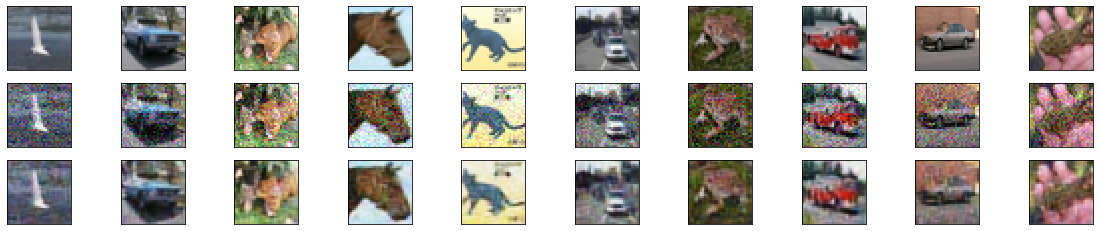

In [0]:

showOrigDec(x_test, x_test_noisy, c10test)

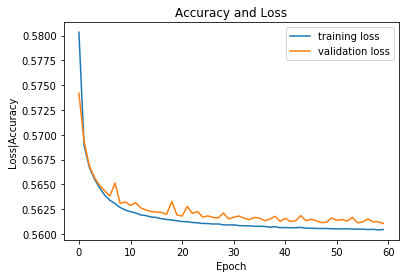

In [0]:
import matplotlib.pyplot as plt
fig = plt.figure()
numOfEpoch = 60
plt.plot(np.arange(0, numOfEpoch), model.history.history['loss'], label='training loss')
plt.plot(np.arange(0, numOfEpoch), model.history.history['val_loss'], label='validation loss')
#plt.plot(np.arange(0, numOfEpoch), model.history.history['acc'], label='accuracy')
#plt.plot(np.arange(0, numOfEpoch), model.history.history['val_acc'], label='validation accuracy')
plt.title('Accuracy and Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss|Accuracy')
plt.legend()

In [0]:
model.save("../content/drive/My Drive/Colab Notebooks/trinhviethoang/cifar10_noisyautoencoder.h5")

In [0]:
from keras.models import load_model
model = load_model("../content/drive/My Drive/Colab Notebooks/cifar10_noisyautoencoder.h5")
score = model.evaluate(x_test, x_test_noisy, verbose=0)
print(score)

OSError: ignored